In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
imageSizes={}
imageSizes['disease13']=(22210, 22344)
imageSizes['control13']=(22355, 18953)
imageSizes['disease8']=(22294, 19552)
imageSizes['control8']=(22452, 19616)

In [4]:
# get cluster map

inverseAct=None
# inverseAct=None
minCells=15 #min number of cells for analysis
minCell_clusterDE=5
clustermethod=['leiden']
# clustermethod=['leiden','agglomerative','kmeanbatch']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
resolution=0.2
plotepoch=1200
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10,15]
aggMetric=['euclidean']


combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

seed=3

plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['logminmax']
diamThresh_mul=800
minThresh_mul=12
overlap=0
name='all_thresh25min12_01'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnn_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnn_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnn_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
imageslist={}
for s in plot_samples.keys():
    imageslist[s]=loadImage.loadandsplit(plot_samples[s],datadir,diamThresh_mul,overlap,0,0,ifFlip=True,minCutoff=minThresh_mul,seed=seed,split=False,imagename='pi_sum.tif',minmaxscale=True,returnPos=True)
    imageslist[s]=imageslist[s][1]


coordsList=None
samplenameList=None

for s in plot_samples.keys():
    coord=imageslist[s]
    
    if coordsList is None:
        coordsList=coord
        samplenameList=np.repeat(s,coord.shape[0])
    else:
        coordsList=np.vstack((coordsList,coord))
        samplenameList=np.concatenate((samplenameList,np.repeat(s,coord.shape[0])),axis=None)
coordsList=coordsList.astype('int')

sampledir=os.path.join(plotsavepath,'combined')
if inverseAct:
    sampledir+='_beforeAct'
clustersavedir=os.path.join(sampledir,'cluster')
    
def mapLeiden(coords,samplenameList,imageSizes,n_neighbors,n_pcs,min_dist,resolution):
    savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(resolution)+'epoch'+str(plotepoch)
    readpath=os.path.join(clustersavedir,savenamecluster)
    if not os.path.exists(readpath):
        print('DNE: '+readpath)
    with open(readpath, 'rb') as input:
        labels = pickle.load(input)
    labels=np.array(labels)

    radius=int(diamThresh_mul/2)
    clusterMapList={}
    for s in np.unique(samplenameList):
        samplename=plot_samples[s]
        clusterMapList[s]=np.zeros(imageSizes[s])-1
    for i in range(coords.shape[0]):
        centroid=coords[i]
        s=samplenameList[i]
        image=clusterMapList[s]
        rowstart=max(0,centroid[0]-radius)
        rowEnd=min(image.shape[0],centroid[0]+radius)
        colstart=max(0,centroid[1]-radius)
        colEnd=min(image.shape[1],centroid[1]+radius)
        clusterMapList[s][rowstart:rowEnd,colstart:colEnd]=labels[i]
    for s in np.unique(samplenameList):
        samplename=plot_samples[s]
        print('unflipping clusterMap')
        if samplename=='AD_mouse9494':
            clusterMapList[s]=np.flipud(clusterMapList[s])
        elif samplename=='AD_mouse9498':
            clusterMapList[s]=np.fliplr(clusterMapList[s])
        elif samplename=='AD_mouse9735':
            clusterMapList[s]=np.flipud(clusterMapList[s])
            clusterMapList[s]=np.fliplr(clusterMapList[s])
        clusterMapList[s]=clusterMapList[s].astype('int')
    return clusterMapList

if 'leiden' in clustermethod:
    clusterMapList=mapLeiden(coordsList,samplenameList,imageSizes,n_neighbors,n_pcs,min_dist,resolution)

(22210, 22344)
flipping images
(22355, 18953)
flipping images
no cells
no cells
no cells
(22294, 19552)
flipping images
(22452, 19616)
flipping images
unflipping clusterMap
unflipping clusterMap
unflipping clusterMap
unflipping clusterMap


In [5]:
# Settings for clf
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
epochs=1000
saveFreq=10
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='alexnet'

kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=512
hidden5=512
fc_dim1=512*25*25
fc_dim2=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13']
targetBatch=None
switchFreq=10
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7
name='disease13_thresh25min12_overlap70area70_03'
logsavepath='/mnt/external_ssd/xinyi/log/train_cnnClf_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_cnnClf_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnnClf_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [6]:
plaqueCentroids={}
plaqueCentroids['disease13']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9494/trimmed_images/PlaqueMask.csv', header=0)
plaqueCentroids['disease8']=pd.read_csv('/home/xinyiz/2021-01-13-mAD-test-dataset/AD_mouse9723/trimmed_images/PlaqueMask.csv', header=0)
maxArea=max(np.max(plaqueCentroids['disease13']['Area']),np.max(plaqueCentroids['disease8']['Area']))
plaqueCutoffRadius=max(int(np.sqrt(maxArea)/2),int(diamThresh_mul/2))

In [7]:
coordsList=None
samplenameList=None
imageslist={}
for s in ['disease13','disease8']:
    imageslist[s]=loadImage.loadandsplitPlaque_overlap(areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)


(22210, 22344)
plaque1959
no plaque2434
(22294, 19552)
plaque758
no plaque3283


In [8]:
for s in ['control13','control8']:
    imageslist[s]=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,0,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    

(22355, 18953)
no cells
no cells
(22452, 19616)


In [9]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [10]:
npos=0
nneg=0
for s in training_samples:
    npos=np.sum(imageslist['disease13'][3])
    nneg=imageslist['disease13'][3].shape[0]-npos
print(npos)
print(nneg)

1668
2066


In [11]:
mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='alexnet':
    model = modelsCNN.AlexNet(2)
    lossCE=torch.nn.CrossEntropyLoss(torch.tensor([(nneg+npos)/nneg,(nneg+npos)/npos]).cuda().float())

# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [12]:
radius=int(diamThresh_mul/2)
def plotLoss(inputNp,labelsNp,coordNp,name,clusterMap,savepath,savenameAdd=''):
    if 'disease' in s:
        lossMap_counts_pos=np.zeros(imageSizes[s])
    lossMap_pos=np.zeros(imageSizes[s])
    lossMap_neg=np.zeros(imageSizes[s])
    lossMap_counts_neg=np.zeros(imageSizes[s])
#     loss_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        centroid=coordNp[i]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().long()
        pred = model(testInput)
        loss_test_curr=lossCE(pred,labels).item()
        
        rowstart=max(0,centroid[0]-radius)
        rowEnd=min(imageSizes[s][0],centroid[0]+radius)
        colstart=max(0,centroid[1]-radius)
        colEnd=min(imageSizes[s][1],centroid[1]+radius)
        
        if labels==1:
            lossMap_pos[rowstart:rowEnd,colstart:colEnd]+=loss_test_curr
            lossMap_counts_pos[rowstart:rowEnd,colstart:colEnd]+=1
        else:
            lossMap_neg[rowstart:rowEnd,colstart:colEnd]+=loss_test_curr
            lossMap_counts_neg[rowstart:rowEnd,colstart:colEnd]+=1
#     print('wrong pixles: '+str(np.sum(np.logical_and(lossMap_counts_pos>0,lossMap_counts_neg>0))))
    inputNp=None
    if 'disease' in s:
        nonzeroIdx_pos=(lossMap_counts_pos!=0)
        lossMap_pos[nonzeroIdx_pos]=lossMap_pos[nonzeroIdx_pos]/lossMap_counts_pos[nonzeroIdx_pos]
    nonzeroIdx_neg=(lossMap_counts_neg!=0)
    lossMap_neg[nonzeroIdx_neg]=lossMap_neg[nonzeroIdx_neg]/lossMap_counts_neg[nonzeroIdx_neg]
    
    if 'disease' in s:
        lossMap_counts_pos=None
    lossMap_counts_neg=None
    
    clusters=np.unique(clusterMap)
    clusters=np.max(clusters) #correction: +1
    clusterPosloss=np.zeros(clusters)-1
    clusterNegloss=np.zeros(clusters)-1
    for c in range(clusters):
        if 'disease' in s:
            clusterPosloss[c]=np.mean(lossMap_pos[np.logical_and(nonzeroIdx_pos,clusterMap==c)])
        clusterNegloss[c]=np.mean(lossMap_neg[np.logical_and(nonzeroIdx_neg,clusterMap==c)])
    
    lossMap_neg[nonzeroIdx_neg]=lossMap_neg[nonzeroIdx_neg]/np.max(lossMap_neg[nonzeroIdx_neg])
    if 'disease' in s:
        lossMap_pos[nonzeroIdx_pos]=lossMap_pos[nonzeroIdx_pos]/np.max(lossMap_pos[nonzeroIdx_pos])
        zeroIdx_all=np.logical_not(np.logical_or(nonzeroIdx_pos,nonzeroIdx_neg))
    else:
        zeroIdx_all=np.logical_not(nonzeroIdx_neg)
    lossMap_not=np.zeros(imageSizes[s])
    lossMap_not[zeroIdx_all]=1
    img=np.stack((lossMap_pos,lossMap_neg,lossMap_not),axis=2)
    lossMap_pos=None
    lossMap_neg=None
    lossMap_not=None
    plt.imsave(os.path.join(savepath,'lossDistr_'+s+name+savenameAdd+'.jpg'),img)
    plt.close()
    return clusterPosloss,clusterNegloss

testepoch=20
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
savepath=os.path.join(plotsavepath,'LossDistribution_testepoch'+str(testepoch)+'leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(resolution)+'epoch'+str(plotepoch))
if not os.path.exists(savepath):
    os.mkdir(savepath)
clusterPoslossTest={}
clusterNeglossTest={}
clusterPoslossTrain={}
clusterNeglossTrain={}
clusterPoslossVal={}
clusterNeglossVal={}
clusterPoslossAll={}
clusterNeglossAll={}
for s in sampleidx.keys():
    print(s)
    trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist[s]
    trainCoordnp=trainCoordnp.astype('int')
    valCoordnp=valCoordnp.astype('int')
    testCoordnp=testCoordnp.astype('int')
#     clusterPoslossAll[s],clusterNeglossAll[s]=plotLoss(np.concatenate((trainInputnp,valInputnp,testInputnp),axis=0),np.concatenate((trainLabelsnp,valLabelsnp,testLabelsnp)),np.concatenate((trainCoordnp,valCoordnp,testCoordnp),axis=0),'all',clusterMapList[s],savepath)
    clusterPoslossTest[s],clusterNeglossTest[s]=plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',clusterMapList[s],savepath)
    clusterPoslossTrain[s],clusterNeglossTrain[s]=plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',clusterMapList[s],savepath)
    clusterPoslossVal[s],clusterNeglossVal[s]=plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',clusterMapList[s],savepath)
    

disease13
control13
disease8


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


control8


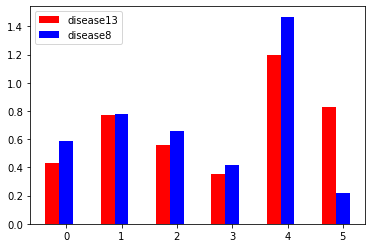

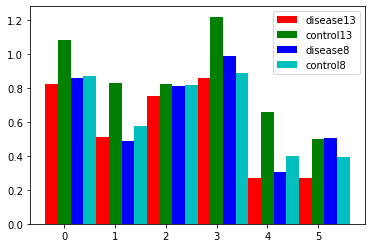

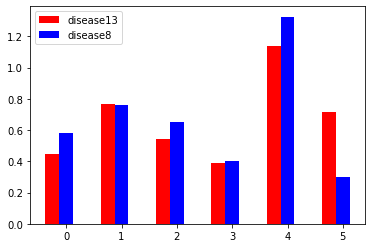

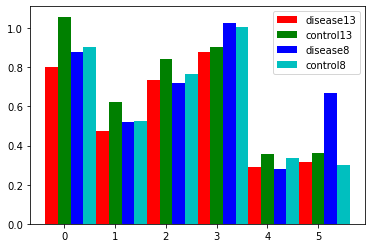

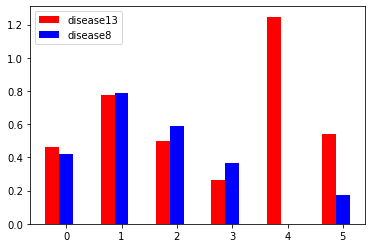

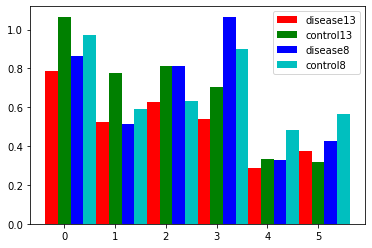

In [13]:
def plotLossDistr(lossDict,savepath,savename):
    barWidth = 0.25
    fig = plt.subplots()

    xlabels=[i for i in lossDict.keys()]
    color=['r','g','b','c']
    idx=0
    for sidx in range(len(xlabels)):
        s=xlabels[sidx]
        if np.sum(lossDict[s]!=-1)==0:
            continue
        
        brs=np.arange(lossDict[s].size)+idx*barWidth
        plt.bar(brs,lossDict[s],color=color[sidx],width=barWidth,label=s,edgecolor=None)
        idx+=1
    plt.xticks(np.arange(lossDict[s].size)+barWidth,
            np.arange(lossDict[s].size))

    plt.legend()
    plt.savefig(os.path.join(savepath,savename+'.jpg'))

plotLossDistr(clusterPoslossTest,savepath,'lossByCluster_testPos')
plotLossDistr(clusterNeglossTest,savepath,'lossByCluster_testNeg')
plotLossDistr(clusterPoslossTrain,savepath,'lossByCluster_trainPos')
plotLossDistr(clusterNeglossTrain,savepath,'lossByCluster_trainNeg')
plotLossDistr(clusterPoslossVal,savepath,'lossByCluster_ValPos')
plotLossDistr(clusterNeglossVal,savepath,'lossByCluster_ValNeg')